In [116]:
!pip install imageio
!pip install imageio-ffmpeg
!pip install dmslogo
!pip install palettable

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import sys
import time
import warnings

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as ag
from torch.distributions.categorical import Categorical

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns


In [3]:
class ParamsBase(nn.Module):
    def __init__(self):
        super().__init__()
        
    @property
    def shape(self):
        return self().shape
    
    def forward(self):
        raise NotImplementedError("Params forward call not implemented.")
        return None
        
    def rebatch(self, input):
        raise NotImplementedError("Rebatch function not implemented.")
        return None
    
    def prior_nll(self):
        raise NotImplementedError("Prior Negative Log-Likelihood not implemented.")
        return None

In [4]:
class BasicParameters(ParamsBase):
    def __init__(self,
                 data,
                 left_flank=None,
                 right_flank=None,
                 batch_dim=0,
                 cat_axis=-1
                ):
        
        super().__init__()
        
        self.register_parameter('theta', data)
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank)
        
        self.cat_axis = cat_axis
        self.batch_dim = batch_dim
        
    @property
    def shape(self):
        return self().shape

    def forward(self):
        my_attr = [ getattr(self, x) for x in ['theta', 'left_flank', 'right_flank'] ]
        return torch.cat( [ x for x in my_attr if x is not None ], axis=self.cat_axis )
    
    def rebatch(self, input):
        return input


In [5]:
my_params = BasicParameters(
    nn.Parameter(torch.randn([3,4,1])), 
    left_flank=None, 
    right_flank=None
)

In [6]:
class StraightThroughParameters(ParamsBase):
    def __init__(self,
                 data,
                 left_flank=None,
                 right_flank=None,
                 batch_dim=0,
                 cat_axis=-1,
                 n_samples=1,
                 temperature=1.,
                ):
        
        super().__init__()
        
        self.register_parameter('theta', data)
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank)
        
        self.cat_axis = cat_axis
        self.batch_dim = batch_dim
        self.n_samples = n_samples
        self.temperature = temperature
        
        self.softmax    = nn.Softmax(dim=-1)
        self.num_classes= self.theta.shape[1]
        self.n_dims     = len(self.theta.shape)
        self.batch_size = self.theta.shape[batch_dim]
        
        self.perm_order   = [0] + list(range(2,self.n_dims)) + [1]
        self.reverse_perm = [0,self.n_dims-1] + list(range(1,self.n_dims-1))
                
    @property
    def shape(self):
        return get_logits().shape
    
    def get_logits(self):
        my_attr = [ getattr(self, x) for x in ['theta', 'left_flank', 'right_flank'] ]
        return torch.cat( [ x for x in my_attr if x is not None ], axis=self.cat_axis )
    
    def get_probs_and_dist(self):
        logits = self.get_logits()
        logits = logits.permute( *self.perm_order ) \
                   .div(self.temperature)
        probs  = self.softmax(logits)
        dist   = Categorical(probs=probs)
        return probs, dist
    
    def sample(self):
        probs, dist = self.get_probs_and_dist()
        sample = dist.sample((self.n_samples,))
        sample = F.one_hot(sample, self.num_classes)
        sample = sample - probs.detach() + probs
        sample = sample.flatten(0,1)
        sample = sample.permute( *self.reverse_perm )
        return sample
    
    def forward(self):
        return self.sample()
    
    def rebatch(self, input):
        return input.unflatten(0, (self.n_samples, self.batch_size)).mean(dim=0)
    
class GumbelSoftmaxParameters(ParamsBase):
    def __init__(self,
                 data, 
                 left_flank=None,
                 right_flank=None,
                 batch_dim=0,
                 cat_axis=-1,
                 n_samples=1,
                 tau=1.,
                 prior_var=1.
                ):
        
        super().__init__()
        self.register_parameter('theta', data)
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank)
        
        self.cat_axis = cat_axis
        self.batch_dim = batch_dim
        self.n_samples = n_samples
        self.tau = tau
        self.prior_var = prior_var
        
        self.softmax    = nn.Softmax(dim=-1)
        self.num_classes= self.theta.shape[1]
        self.n_dims     = len(self.theta.shape)
        self.batch_size = self.theta.shape[batch_dim]
        
    @property
    def shape(self):
        return get_logits().shape
    
    def get_logits(self):
        my_attr = [ getattr(self, x) for x in ['theta', 'left_flank', 'right_flank'] ]
        return torch.cat( [ x for x in my_attr if x is not None ], axis=self.cat_axis )
    
    def get_sample(self):
        logits = self.get_logits()
        samples= [ F.gumbel_softmax(logits, tau=self.tau, hard=True, dim=1) 
                   for i in range(self.n_samples) ]
        return torch.stack(samples, dim=0)
    
    def forward(self):
        sample = self.get_sample()
        return sample.flatten(0,1)
        
    def rebatch(self, input):
        return input.unflatten(0, (self.n_samples, self.batch_size)).mean(dim=0)
    
    def prior_nll(self):
        return self.theta.transpose(self.batch_dim, 0).flatten(1).pow(2).div(2*self.prior_var).mean(1)

In [7]:
class NUTS3(nn.Module):
    def __init__(self,
                 params,
                 energy_fn,
                 max_tree_depth=10
                ):
        
        super().__init__()
        self.params = params
        self.energy_fn  = energy_fn
        self.max_tree_depth = max_tree_depth
        
        self.d_max = 1000.
        
    def calc_energy(self):
        energy = self.energy_fn(self.params())
        energy = self.params.rebatch( energy )
        try:
            prior = self.params.prior_nll()
            energy= energy + prior
        except NotImplementedError:
            warnings.warn("Prior Negative Log-Likelihood Not Implemented.", RuntimeWarning)
            pass
        return energy

    def leapfrog(self, theta, r, epsilon):
        
        self.params.theta.data = theta
        energy = self.calc_energy()
        grad_U = ag.grad( energy.sum(), self.params.theta )[0]
        
        with torch.no_grad():
            r = r - grad_U.mul(epsilon).div(2.)
            
            theta = theta + r.mul(epsilon)
            
        self.params.theta.data = theta
        energy = self.calc_energy()
        grad_U = ag.grad( energy.sum(), self.params.theta )[0]
        
        with torch.no_grad():
            r = r - grad_U.mul(epsilon).div(2.)
            
        return theta, r, energy
        
    def buildtree(self, theta, r, u, v, j, epsilon):
        #print(f'current j: {j}')
        if j == 0:
            theta_p, r_p, energy_p = self.leapfrog(theta, r, v*epsilon)
            batch_dot = torch.einsum('bs,bs->b', r_p.flatten(1), r_p.flatten(1))
            hamilton  = energy_p + batch_dot.div(2.)
            n_p = (u <= torch.exp(-hamilton)).type(torch.long)
            s_p = (torch.log(u).add(-self.d_max) < -hamilton).type(torch.long)
            #print(f'inner j: {j}')
            #print(f'log u: {u.log()}, -H: {-hamilton}')
            #print(theta_p, r_p, theta_p, r_p, theta_p, n_p, s_p, sep='\n')
            return theta_p, r_p, theta_p, r_p, theta_p, n_p, s_p
        
        else:
            #print(f'inner j: {j}')
            bt_pack = self.buildtree(theta, r, u, v, j-1, epsilon)
            theta_r, r_r, theta_f, r_f, theta_p, n_p, s_p = bt_pack
            #[print(a) for a in bt_pack]
            if s_p.sum() > 0:
                if v == -1:
                    bt_pack = self.buildtree(theta_r, r_r, u, v, j-1, epsilon)
                    theta_r, r_r, _, _, theta_pp, n_pp, s_pp = bt_pack
                    
                else:
                    bt_pack = self.buildtree(theta_f, r_f, u, v, j-1, epsilon)
                    _, _, theta_f, r_f, theta_pp, n_pp, s_pp = bt_pack
                
                update_flag = torch.rand(n_pp.size(), dtype=torch.float, 
                                         layout=n_pp.layout, device=n_pp.device)
                update_flag = update_flag < n_pp.div( n_p + n_pp )
                update_flag = torch.logical_and(update_flag, s_p.ge(1) )
                theta_p[ update_flag ] = theta_pp[ update_flag ]
                s_p = s_p * s_pp * \
                      torch.einsum('bs,bs->b', (theta_f - theta_r).flatten(1), r_r.flatten(1)) \
                        .ge(0.).type(torch.long) * \
                      torch.einsum('bs,bs->b', (theta_f - theta_r).flatten(1), r_f.flatten(1)) \
                        .ge(0.).type(torch.long)
                n_p = n_p + n_pp
            #print(theta_r, r_r, theta_f, r_f, theta_p, n_p, s_p)
            return theta_r, r_r, theta_f, r_f, theta_p, n_p, s_p
        
    def init_trajectory(self, theta):
        with torch.no_grad():
            r_0 = torch.randn_like( theta )
            energy_0 = self.calc_energy()
            batch_dot= torch.einsum('bs,bs->b', r_0.flatten(1), r_0.flatten(1))
            hamilton = energy_0 + batch_dot.div(2.)
            u   = torch.rand_like( hamilton ).mul( torch.exp(-hamilton) )
            
            theta_r, theta_f = theta, theta
            r_r, r_f = r_0, r_0
            j = 0
            theta_m = theta
            n = torch.ones(batch_dot.size(), dtype=torch.long, layout=batch_dot.layout, device=batch_dot.device)
            s = torch.ones(batch_dot.size(), dtype=torch.long, layout=batch_dot.layout, device=batch_dot.device)
        return u, theta_r, r_r, theta_f, r_f, j, theta_m, n, s
    
    def sample_trajectory(self, theta, epsilon):
        u, theta_r, r_r, theta_f, r_f, j, theta_m, n, s = self.init_trajectory(theta)
        while (s.sum() >= 1) and (j < self.max_tree_depth):
            v = torch.randn([1], dtype=torch.float, layout=theta.layout, device=theta.device) \
                  .ge(0.).mul(2.).add(-1.)
            if v < 0:
                theta_r, r_r, _, _, theta_p, n_p, s_p = self.buildtree(theta_r, r_r, u, v, j, epsilon)
            else:
                _, _, theta_f, r_f, theta_p, n_p, s_p = self.buildtree(theta_f, r_f, u, v, j, epsilon)
            
            #print('traj results:')
            #print(theta_r, r_r, theta_f, r_f, theta_p, n_p, s_p, sep='\n')
            update_flag = torch.rand_like(n.type(torch.float))
            update_flag = update_flag <= torch.minimum( n / n_p, torch.ones_like(n.type(torch.float)) )
            update_flag = torch.logical_and( update_flag, s.ge(1) )
            update_flag = torch.logical_and( update_flag, s_p.ge(1) )
            #print(f'update_flag: {update_flag}')
            theta_m[ update_flag ] = theta_p[ update_flag ]
            
            n = n + n_p
            s = s * s_p * \
                torch.einsum('bs,bs->b', (theta_f - theta_r).flatten(1), r_r.flatten(1)) \
                  .ge(0.).type(torch.long) * \
                torch.einsum('bs,bs->b', (theta_f - theta_r).flatten(1), r_f.flatten(1)) \
                  .ge(0.).type(torch.long)
            j = j + 1
        
        return theta_m.detach().clone()
    
    def collect_samples(self, epsilon, n_samples=1):
        samples = []
        theta_m = self.params.theta.clone().detach()
        for m in range(n_samples):
            theta_m = self.sample_trajectory( theta_m, epsilon )
            with torch.no_grad():
                self.params.theta.data = theta_m
                samples.append( [theta_m, self.calc_energy()] )
        return samples


In [80]:
class a_frac(nn.Module):
    def __init__(self, frac=0.2):
        super().__init__()
        self.frac = frac
        self.energy = nn.KLDivLoss(reduction='none')
        
    def forward(self, in_tensor):
        score = in_tensor[:,0,:].mean(1).add(1e-5).log()
        labs  = torch.full_like(score, self.frac)
        return self.energy(score, labs)

class a_frac(nn.Module):
    def __init__(self, frac=0.2):
        super().__init__()
        self.frac = frac
        self.energy = nn.KLDivLoss(reduction='none')
        
    def forward(self, in_tensor):
        score = in_tensor[:,0,:].mean(1).add(-self.frac).pow(2)
        return score

class a_only(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.CrossEntropyLoss(reduction='none')
        
    def forward(self, in_tensor):
        score = in_tensor.sum(-1)
        targs = torch.zeros(in_tensor.shape[0],
                            layout=in_tensor.layout,
                            device=in_tensor.device).long()
        return self.loss(score, targs)
        
class hard_motif(nn.Module):
    def __init__(self, motif):
        super().__init__()
        self.motif = motif
        self.loss  = nn.KLDivLoss(reduction='none', log_target=True)
        
    def forward(self, in_tensor):
        return self.loss( in_tensor, self.motif ).sum(-1).mean(-1)
    
class scan_motif(nn.Module):
    def __init__(self, motif):
        super().__init__()
        self.motif = motif
        self.filter= nn.Conv1d(motif.shape[1], motif.shape[0], motif.shape[2], 
                               bias=False)
        self.filter.weight.data = motif
        self.filter.weight.requires_grad = False
        self.activation = nn.LogSigmoid()
        
    def forward(self, in_tensor):
        hook = self.filter(in_tensor)
        hook = hook.max(-1)[0]
        #hook = self.activation(hook)
        hook = hook.mul(-1).sum(-1)
        return hook
    
class run_filter(nn.Module):
    def __init__(self, motif):
        super().__init__()
        self.motif = motif
        self.filter= nn.Conv1d(motif.shape[1], motif.shape[0], motif.shape[2], 
                               bias=False)
        self.pad = nn.ConstantPad1d((0,self.filter.weight.shape[-1]-1),motif.min())
        self.filter.weight.data = motif
        self.filter.weight.requires_grad = False

    def forward(self, in_tensor):
        hook = self.filter(in_tensor)
        return self.pad( hook )


In [ ]:
tensor_to_dmsheat(sampled_theta, run_filter(motif_filter))

In [9]:
my_params = StraightThroughParameters(
    nn.Parameter(torch.randn([1,4,1])), 
    left_flank=None, 
    right_flank=None,
    n_samples=2
)

my_params = GumbelSoftmaxParameters(
    nn.Parameter(torch.randn([1,4,1])), 
    left_flank=None, 
    right_flank=None,
    n_samples=100
)

In [10]:
my_energy = a_only()


In [11]:
test = my_params()
print(test.sum(-1))
print(test.sum(-1)[:,0])
print( my_energy(test)[torch.argmax(test.sum(-1)[:,0])] )
print( test[torch.argmax(test.sum(-1)[:,0])] )
print( my_energy( test ).min() )
print( my_energy( test ).max() )
print( test[my_energy( test ).argmin()] )
print( test[my_energy( test ).argmax()] )
my_energy( test )

tensor([[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0.,

tensor([1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437,
        1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437,
        1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437,
        1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437,
        1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437,
        1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437,
        1.7437, 1.7437, 1.7437, 0.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437,
        1.7437, 1.7437, 1.7437, 1.7437, 0.7437, 1.7437, 1.7437, 1.7437, 1.7437,
        1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437,
        1.7437, 1.7437, 1.7437, 1.7437, 0.7437, 1.7437, 1.7437, 1.7437, 1.7437,
        0.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437, 1.7437,
        1.7437], grad_fn=<NllLossBackward>)

In [12]:
my_params.rebatch( my_energy( test ) )

tensor([1.7037], grad_fn=<MeanBackward1>)

In [13]:
my_sampler = NUTS3( my_params, my_energy, max_tree_depth=5 )

In [14]:
my_sampler.calc_energy()

tensor([2.9568], grad_fn=<AddBackward0>)

In [15]:
my_sampler.params.theta

Parameter containing:
tensor([[[-0.4599],
         [ 1.2651],
         [ 1.1355],
         [-2.7210]]], requires_grad=True)

In [16]:
my_sampler.params.theta.argmax(1)

tensor([[1]])

In [17]:
start = time.time()
my_samples = my_sampler.collect_samples(1e-1,1000)
print(time.time() - start)

/opt/conda/lib/python3.7/site-packages/torch/autograd/__init__.py:204: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/c10/cuda/CUDAFunctions.cpp:100.)
  inputs, allow_unused)


1242.592767715454


In [33]:
sampled_theta, sampled_energy = [ torch.stack(x, dim=0) for x in zip(*my_samples) ]

In [19]:
print(sampled_theta.shape)
print(sampled_energy.shape)

torch.Size([1000, 1, 4, 1])
torch.Size([1000, 1])


In [20]:
b_dim = 0
cpu_theta = sampled_theta.mean(-1)[-200:,b_dim,0].cpu().numpy()
cpu_energy= sampled_energy[-200:,b_dim].cpu().numpy()

In [21]:
cpu_theta

array([ 9.6656990e-01, -4.5952031e-01,  1.3175269e+00,  1.0837963e+00,
        1.3887939e+00,  1.9131925e+00,  1.6904452e+00,  8.6935654e-02,
        1.2728255e+00,  4.5032017e-02, -8.7228373e-02, -4.6234420e-01,
       -1.4636239e+00, -3.1705377e+00, -2.8481970e+00,  5.7336181e-01,
       -2.5337303e-01, -1.1356335e+00,  1.3514887e-01, -4.5133236e-01,
        1.3287396e+00,  5.0243419e-01, -2.1349692e-01,  2.8751936e+00,
        1.5708934e+00,  6.0324305e-01, -1.6261281e+00, -1.1138576e+00,
        2.7282047e-01,  2.6310246e+00,  2.4270847e+00,  1.8574253e+00,
        1.1382709e+00,  3.2439032e+00,  2.7429719e+00, -1.7463335e-01,
        2.0923831e+00, -2.2617383e+00, -2.0980105e+00, -1.9261410e+00,
       -1.8147626e+00,  1.7648700e+00,  3.2563555e+00,  1.9735677e+00,
        1.6182250e+00,  4.0755215e+00,  2.1036532e+00,  7.7162498e-01,
        1.5571843e+00,  1.9114064e+00, -5.5311018e-01,  5.3107888e-01,
        3.5383618e-01,  7.5543392e-01, -5.1923847e-01,  8.8705099e-01,
      

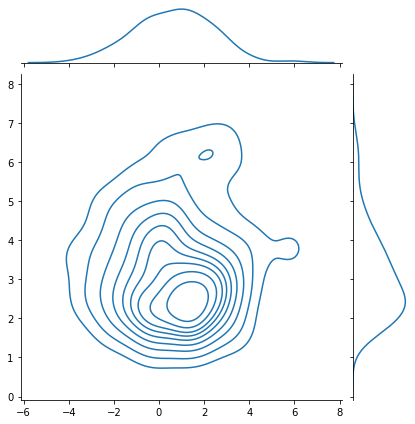

In [22]:
g = sns.jointplot(x = cpu_theta, 
                  y = cpu_energy,
                  kind='kde'
                 )
plt.show()

# Sample directly from GATA1 motif

In [9]:
motif = """1114.00 206.00 318.00 4955.00   0.00   0.00 2049.00 658.00 963.00 1191.00 1778.00 1038.00 1352.00 1885.00 1381.00 110.00 4659.00 160.00
2038.00 807.00   0.00   0.00   0.00 4955.00  63.00 1331.00 1214.00 1127.00 1130.00 1237.00 1142.00 1033.00 1237.00 4822.00   0.00 890.00
967.00 159.00   0.00   0.00   0.00   0.00  55.00 2214.00 1244.00 1520.00 990.00 1712.00 1466.00 820.00 1884.00  23.00   0.00 3544.00
836.00 3783.00 4637.00   0.00 4955.00   0.00 2788.00 752.00 1534.00 1117.00 1057.00 968.00 995.00 1217.00 453.00   0.00 296.00 361.00"""

In [10]:
def motif_str_to_counts(motif_str, pseudocounts=1.0):
    motif = torch.tensor( [ list([ float(y) for y in x.split() ]) for x in motif_str.split('\n') ] )
    return motif.add(pseudocounts)

def counts_to_ppm(in_tensor):
    motif = in_tensor.div( in_tensor.sum(0) )
    return motif

def ppm_to_pwm(in_tensor,bkg=[0.25,0.25,0.25,0.25]):
    motif = in_tensor.div(torch.tensor(bkg).unsqueeze(1)).log2()
    return motif

def ppm_to_U(in_tensor):
    return (in_tensor.log2() * in_tensor).sum(0).mul(-1.)

def ppm_to_IC(in_tensor):
    return in_tensor * ppm_to_U( in_tensor ).mul(-1.).add(2.)

def PWM_to_filter(motif_str):
    motif = torch.tensor( [ list([ float(y) for y in x.split() ]) for x in motif_str.split('\n') ] )
    motif = motif.add(1.).div( motif.add(1.).sum(0) )
    motif = motif.div( motif.add(-1).mul(-1) ).log().clamp(-5,5)
    motif = torch.randn_like(motif).mul(1e-3).add(motif)
    motif = motif.add(-motif.mean(0))
    return motif

def counts_to_filter(in_tensor):
    motif = ppm_to_pwm( counts_to_ppm( in_tensor ) )
    return motif.unsqueeze(0)

In [11]:
ppm_to_pwm( counts_to_ppm( motif_str_to_counts(motif) ) )

tensor([[-1.5301e-01, -2.5823e+00, -1.9584e+00,  1.9991e+00, -1.0276e+01,
         -1.0276e+01,  7.2557e-01, -9.1170e-01, -3.6294e-01, -5.6665e-02,
          5.2102e-01, -2.5485e-01,  1.2611e-01,  6.0528e-01,  1.5671e-01,
         -3.4814e+00,  1.9103e+00, -2.9449e+00],
        [ 7.1781e-01, -6.1762e-01, -1.0276e+01, -1.0276e+01, -1.0276e+01,
          1.9991e+00, -4.2758e+00,  1.0354e-01, -2.9093e-02, -1.3628e-01,
         -1.3245e-01, -2.0379e-03, -1.1722e-01, -2.6181e-01, -2.0379e-03,
          1.9599e+00, -1.0276e+01, -4.7655e-01],
        [-3.5697e-01, -2.9539e+00, -1.0276e+01, -1.0276e+01, -1.0276e+01,
         -1.0276e+01, -4.4685e+00,  8.3726e-01,  6.0964e-03,  2.9497e-01,
         -3.2309e-01,  4.6648e-01,  2.4282e-01, -5.9460e-01,  6.0452e-01,
         -5.6909e+00, -1.0276e+01,  1.5157e+00],
        [-5.6675e-01,  1.6099e+00,  1.9035e+00, -1.0276e+01,  1.9991e+00,
         -1.0276e+01,  1.1697e+00, -7.1933e-01,  3.0819e-01, -1.4913e-01,
         -2.2871e-01, -3.5548e-01, -3.1

In [12]:
ppm_to_IC( counts_to_ppm( motif_str_to_counts(motif) ) )

tensor([[2.1451e-02, 3.8598e-02, 1.0615e-01, 1.9905e+00, 4.0163e-04, 4.0163e-04,
         3.5227e-01, 2.2778e-02, 3.7411e-03, 2.9400e-03, 1.5548e-02, 7.9133e-03,
         4.3075e-03, 2.6964e-02, 3.9090e-02, 4.0259e-02, 1.5670e+00, 2.5085e-02],
        [3.9227e-02, 1.5066e-01, 3.3275e-04, 4.0163e-04, 4.0163e-04, 1.9905e+00,
         1.0998e-02, 4.6039e-02, 4.7152e-03, 2.7822e-03, 9.8849e-03, 9.4289e-03,
         3.6389e-03, 1.4783e-02, 3.5017e-02, 1.7493e+00, 3.3626e-04, 1.3883e-01],
        [1.8623e-02, 2.9835e-02, 3.3275e-04, 4.0163e-04, 4.0163e-04, 4.0163e-04,
         9.6230e-03, 7.6559e-02, 4.8316e-03, 3.7515e-03, 8.6613e-03, 1.3047e-02,
         4.6704e-03, 1.1738e-02, 5.3318e-02, 8.7046e-03, 3.3626e-04, 5.5235e-01],
        [1.6102e-02, 7.0559e-01, 1.5433e+00, 4.0163e-04, 1.9905e+00, 4.0163e-04,
         4.7926e-01, 2.6027e-02, 5.9570e-03, 2.7575e-03, 9.2468e-03, 7.3802e-03,
         3.1709e-03, 1.7413e-02, 1.2842e-02, 3.6269e-04, 9.9868e-02, 5.6403e-02]])

In [54]:
from Bio.Seq import Seq
from Bio import motifs

import imageio

def two_pngs(png1,png2,target='compound_image.png',dpi=200):
    img1 = plt.imread(png1)
    img2 = plt.imread(png2)

    plt.figure(1,figsize=(12,6),dpi=dpi)
    plt.subplot(211)
    plt.imshow(img1)
    plt.axis('off')

    plt.subplot(212)
    plt.imshow(img2)
    plt.axis('off')
    plt.savefig(target)
    plt.close()

def seqs_from_tensor(in_tensor):
    n_samples = 100
    samples = [ F.gumbel_softmax(in_tensor, tau=1., hard=True, dim=0) 
                for i in range(n_samples) ]
    samples = torch.stack(samples, dim=0).argmax(1)
    seqs = []
    for i in range(samples.shape[0]):
        seqs.append(Seq("".join([ ['A','C','G','T'][x.item()] for x in samples[i] ])))
    return seqs

def logo_from_batch(in_tensor, target='my_motif.png'):
    token_tensor = F.gumbel_softmax(in_tensor, tau=1., hard=True, dim=1).argmax(1)
    seqs = []
    for sample in token_tensor:
        seqs.append(Seq(''.join([ ['A','C','G','T'][x.item()] for x in sample ])))
    m = motifs.create(seqs)
    m.weblogo(target,**{'color_scheme': 'color_classic'})
    return m

def logo_from_tensor(in_tensor, target='my_motif.png'):
    instance = seqs_from_tensor(in_tensor)
    m        = motifs.create(instance)
    m.weblogo(target, **{'color_scheme': 'color_classic'})
    return m

def logo_gif(in_tensor, target='my_motif.gif'):
    images = []
    for an_instance in in_tensor:
        _ = logo_from_tensor(an_instance, target='temp_motif.png')
        images.append( imageio.imread('temp_motif.png') )
    imageio.mimsave(target, images, duration=0.01)
    return images

def logo_video(in_tensor, target='my_motif.mp4'):
    images = []
    writer = imageio.get_writer(target, fps=20)
    for an_instance in in_tensor:
        _ = logo_from_tensor(an_instance, target='temp_motif.png')
        images.append( imageio.imread('temp_motif.png') )
    for an_image in images:
        writer.append_data(an_image)
    writer.close()
    return images

def combo_video(theta_tensor, energy_tensor, target='my_motif.mp4'):
    images = []
    writer = imageio.get_writer(target, fps=20)
    hold_range = torch.arange(energy_tensor.shape[0])
    min_e = energy_tensor.min()
    max_e = energy_tensor.max()
    for i, a_theta in enumerate([ x for x in theta_tensor ]):
        _ = logo_from_tensor(a_theta, target='temp_motif.png')
        
        fig = plt.figure(figsize=(12,4))
        ax  = plt.axes()
        ax.plot(hold_range[:i].cpu().numpy(), energy_tensor[:i].cpu().numpy())
        ax.set_xlim(0, energy_tensor.shape[0])
        ax.set_ylim(min_e, max_e)
        ax.set_ylabel('Potential Energy')
        ax.set_xlabel('Iteration')
        fig.savefig('temp_line.png')
        plt.close()
        
        two_pngs('temp_motif.png','temp_line.png','compound_image.png')
        
        images.append( imageio.imread('compound_image.png') )
    for an_image in images:
        writer.append_data(an_image)
    writer.close()
    return images
    
def pssm_to_bits(in_pssm):
    bits_mat = {}
    for NT, scores in in_pssm.items():
        bits_mat[NT] = [ 1. / (1 + (2**(-x))) for x in scores ]
    return bits_mat

In [180]:
import dmslogo
import palettable
import dmslogo.colorschemes
from dmslogo.colorschemes import CBPALETTE

def tensor_to_pandas(in_tensor):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(['A','C','G','T'],[ sub_a for sub_a in my_array ],['green','blue','orange','red']):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def counts_to_dms(in_tensor, ax=None):
    motif = counts_to_ppm( in_tensor )
    motif = ppm_to_IC( motif )
    motif = tensor_to_pandas( motif )
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                ax=ax)
    return fig, ax

def tensor_to_dms(in_tensor, target='dms_motif.png', ax=None):
    n_samples = 100
    samples = [ F.gumbel_softmax(in_tensor, tau=1., hard=True, dim=0) 
                for i in range(n_samples) ]
    samples = torch.stack(samples, dim=0).sum(0).add(0.1)
    fig, ax = counts_to_dms(samples, ax=ax)
    if target is not None:
        fig.savefig(target,dpi=400)
    return fig, ax
    
    
def batch_to_dms(in_tensor, target='dms_motif.png'):
    count_tensor = F.gumbel_softmax(in_tensor, tau=1., hard=True, dim=1).sum(0).add(1.0)
    fig, ax = counts_to_dms(count_tensor)
    fig.savefig(target)

def dms_video(theta_tensor, energy_tensor, target='my_motif.mp4'):
    images = []
    writer = imageio.get_writer(target, fps=25)
    hold_range = torch.arange(energy_tensor.shape[0])
    min_e = energy_tensor.min()
    max_e = energy_tensor.max()
    for i, a_theta in enumerate([ x for x in theta_tensor ]):
        #_ = tensor_to_dms(a_theta, target='dms_motif.png')
        
        fig = plt.figure(figsize=(12,8))
        axes = fig.subplots(nrows=2)
        axes[1].plot(hold_range[:i].cpu().numpy(), energy_tensor[:i].cpu().numpy())
        axes[1].set_xlim(0, energy_tensor.shape[0])
        axes[1].set_ylim(min_e, max_e)
        axes[1].set_ylabel('Potential Energy')
        axes[1].set_xlabel('Iteration')
        _ = tensor_to_dms(a_theta, target=None,ax=axes[0])
        fig.savefig('temp_line.png',dpi=100)
        plt.close()
        
        #two_pngs('dms_motif.png','temp_line.png','compound_image.png',dpi=400)
        
        images.append( imageio.imread('temp_line.png') )
    for an_image in images:
        writer.append_data(an_image)
    writer.close()
    return images

def dmsheat_video(theta_tensor, energy_tensor, scorer, target='my_motif.mp4'):
    images = []
    writer = imageio.get_writer(target, fps=25)
    hold_range = torch.arange(energy_tensor.shape[0])
    min_e = energy_tensor.min()
    max_e = energy_tensor.max()
    scores = scorer(theta_tensor)
    for i, a_theta in enumerate([ x for x in theta_tensor ]):
        #_ = tensor_to_dms(a_theta, target='dms_motif.png')
        
        fig = plt.figure(figsize=(12,8))
        axes = fig.subplots(nrows=3)
        axes[0].imshow(scores[i].cpu().numpy(),vmin=scores.min(),vmax=scores.max())
        axes[2].plot(hold_range[:i].cpu().numpy(), energy_tensor[:i].cpu().numpy())
        axes[2].set_xlim(0, energy_tensor.shape[0])
        axes[2].set_ylim(min_e, max_e)
        axes[2].set_ylabel('Potential Energy')
        axes[2].set_xlabel('Iteration')
        _ = tensor_to_dms(a_theta, target=None,ax=axes[1])
        fig.savefig('temp_line.png',dpi=100)
        plt.close()
        
        #two_pngs('dms_motif.png','temp_line.png','compound_image.png',dpi=400)
        
        images.append( imageio.imread('temp_line.png') )
    for an_image in images:
        writer.append_data(an_image)
    writer.close()
    return images



In [15]:
motif_filter = PWM_to_filter(motif).unsqueeze(0)
motif_filter = counts_to_filter( motif_str_to_counts(motif) )

In [16]:
ppm_to_IC( counts_to_ppm( motif_str_to_counts(motif) ) ).shape

torch.Size([4, 18])

In [17]:
hold_dms = tensor_to_pandas(ppm_to_IC( counts_to_ppm( motif_str_to_counts(motif) ) ))

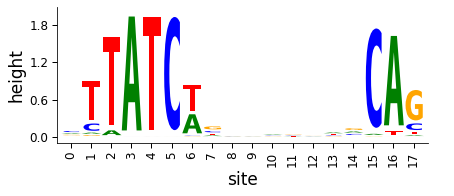

In [18]:
fig, ax = counts_to_dms( motif_str_to_counts(motif) )


In [169]:
hold = motifs.create(seqs_from_tensor(motif_filter.squeeze()))
hold.weblogo('testmotif.png',**{'color_scheme': 'color_classic'})

In [115]:
hold.pseudocounts = { x: .01 for x in hold.pseudocounts.keys()}

In [16]:
motif_filter.squeeze().t()

tensor([[-0.0850,  0.7939, -0.2652, -0.4436],
        [-1.3832,  0.1127, -1.6507,  2.9211],
        [-0.1755, -2.4977, -2.4983,  5.1715],
        [ 7.4999, -2.4999, -2.4988, -2.5013],
        [-2.5001, -2.4992, -2.5011,  7.5004],
        [-2.5004,  7.4997, -2.5004, -2.4989],
        [ 1.8768, -2.1098, -2.2449,  2.4779],
        [-0.6726,  0.2007,  0.9888, -0.5169],
        [-0.3125, -0.0142,  0.0172,  0.3095],
        [-0.0448, -0.1171,  0.2904, -0.1286],
        [ 0.5430, -0.0954, -0.2637, -0.1839],
        [-0.2082,  0.0193,  0.4815, -0.2927],
        [ 0.1284, -0.0969,  0.2418, -0.2733],
        [ 0.6512, -0.1940, -0.4761,  0.0190],
        [ 0.2566,  0.1092,  0.7204, -1.0862],
        [-1.2263,  6.1236, -2.4489, -2.4485],
        [ 5.2476, -2.4987, -2.4987, -0.2502],
        [-1.7614,  0.1168,  2.5532, -0.9086]])

In [19]:
my_params = GumbelSoftmaxParameters(
    nn.Parameter(torch.randn([3,4,18])), 
    left_flank=None, 
    right_flank=None,
    n_samples=20,
    prior_var=4.
)

my_energy = hard_motif(motif_filter)

In [20]:
my_energy( my_params() )

tensor([11372.9004, 11213.5537, 11372.4297, 11324.8604, 10354.3301, 10465.8320,
        10465.6572, 11255.9922, 10467.7568, 11371.4990, 10918.6230, 10472.9131,
        10920.7363, 11257.0967, 10875.6641, 10917.0869, 10870.2510, 11374.0898,
        11254.5020, 11376.6113, 10924.1660, 10460.4023, 11208.5400, 11374.3281,
        10012.9131, 11257.1250, 11373.9941, 11373.0342, 11210.2920, 11373.3477,
        10822.0352, 10832.6113, 10922.4375, 10347.0293, 10919.6191, 10922.6982,
        10878.4287, 10918.2988, 11372.7861, 11258.7520, 11371.1631, 10472.1348,
        10354.6240, 11321.3730, 10924.3223, 10917.6309, 11373.2773, 10875.4473,
        10874.4492, 11258.3945, 10920.8770,  9969.7754, 10872.1367, 10874.8691,
        10865.1133, 10418.2354, 11255.6494, 10357.6123, 11376.1133, 10470.0488],
       grad_fn=<MeanBackward1>)

In [22]:
my_sampler = NUTS3( my_params, my_energy, max_tree_depth=6 )

In [23]:
my_sampler.calc_energy()

tensor([10791.6133, 11020.5801, 10941.3760], grad_fn=<AddBackward0>)

In [24]:
my_sampler.params.theta

Parameter containing:
tensor([[[-1.0924e+00, -1.9324e-01,  5.8821e-01,  7.8947e-01, -1.7907e-01,
          -4.7468e-01, -7.6319e-01,  2.2669e-01, -1.3266e+00, -1.1737e-02,
          -5.4966e-03, -1.0026e+00, -1.8968e+00,  8.0738e-02, -1.3361e+00,
           1.0855e+00, -4.6178e-01, -2.8308e-01],
         [-1.7114e+00,  5.1480e-01, -1.0188e-01, -2.1512e-01, -7.8062e-01,
           6.2006e-01,  1.4228e-01,  1.5512e+00, -5.5406e-01, -2.2320e+00,
          -4.5096e-01, -1.7633e-01,  1.0681e+00,  8.1987e-01, -5.8756e-01,
           9.3440e-02, -1.8784e+00,  7.3087e-01],
         [ 1.5716e+00,  8.6451e-01, -8.2917e-01,  6.7918e-01, -1.2456e+00,
           9.8825e-01, -1.0072e+00,  9.1816e-01,  8.8858e-01,  6.6659e-01,
           9.3008e-01,  1.8613e-01,  6.4460e-01, -5.3661e-01,  3.7945e-03,
           7.4825e-02,  3.9406e-01,  1.0099e+00],
         [ 6.1838e-01,  1.1324e+00, -1.3725e+00,  1.0428e+00,  6.0976e-01,
          -1.4978e+00,  1.2676e+00, -5.6250e-01,  1.5820e-01, -7.7142e-01,
   

In [25]:
my_sampler.params.theta.argmax(1)

tensor([[2, 3, 0, 3, 3, 2, 3, 1, 2, 2, 2, 2, 1, 1, 2, 0, 2, 2],
        [3, 3, 2, 1, 2, 2, 1, 1, 3, 3, 0, 2, 2, 3, 0, 1, 0, 0],
        [2, 2, 0, 1, 1, 1, 0, 2, 0, 1, 1, 3, 2, 2, 0, 2, 3, 0]])

In [26]:
start = time.time()
my_samples = my_sampler.collect_samples(1e-1,1000)
print(time.time() - start)

/opt/conda/lib/python3.7/site-packages/torch/autograd/__init__.py:204: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/c10/cuda/CUDAFunctions.cpp:100.)
  inputs, allow_unused)


753.5387241840363


In [27]:
sampled_theta, sampled_energy = [ torch.stack(x, dim=0) for x in zip(*my_samples) ]

In [28]:
print(sampled_theta.shape)
print(sampled_energy.shape)

torch.Size([1000, 3, 4, 18])
torch.Size([1000, 3])


In [29]:
sampled_theta[:,:,:,5].softmax(-1)

tensor([[[2.4573e-03, 9.9172e-01, 4.1682e-03, 1.6584e-03],
         [3.6904e-02, 8.3082e-01, 6.4147e-02, 6.8129e-02],
         [2.0652e-03, 9.9586e-01, 1.2742e-03, 8.0013e-04]],

        [[6.1265e-06, 9.9998e-01, 3.6980e-06, 1.3997e-05],
         [1.0742e-03, 9.9365e-01, 3.2965e-03, 1.9777e-03],
         [4.8899e-04, 9.9875e-01, 3.8921e-04, 3.7567e-04]],

        [[3.9430e-06, 9.9997e-01, 9.5161e-07, 2.8114e-05],
         [8.1450e-09, 1.0000e+00, 1.8291e-09, 3.1550e-10],
         [1.4775e-08, 9.9999e-01, 1.4072e-05, 1.6007e-08]],

        ...,

        [[2.3343e-04, 9.9975e-01, 1.7569e-05, 9.9654e-12],
         [7.0182e-14, 1.0000e+00, 1.8263e-06, 3.3551e-16],
         [3.3287e-09, 1.0000e+00, 7.4537e-14, 1.5852e-18]],

        [[1.2441e-05, 9.9998e-01, 5.4667e-06, 1.0135e-08],
         [1.7145e-14, 1.0000e+00, 6.2470e-08, 7.3344e-17],
         [1.9588e-11, 1.0000e+00, 4.3945e-12, 1.9640e-18]],

        [[1.2441e-05, 9.9998e-01, 5.4667e-06, 1.0135e-08],
         [1.7145e-14, 1.0000e+00

In [30]:
hold1 = logo_video(sampled_theta[:,0],'traj_1b.mp4')
hold2 = logo_video(sampled_theta[:,1],'traj_2b.mp4')
hold3 = logo_video(sampled_theta[:,2],'traj_3b.mp4')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (324, 107) to (336, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (324, 107) to (336, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (324, 107) to (336, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


# Scan for motif

In [20]:
motif_filter = counts_to_filter( motif_str_to_counts(motif) )

In [21]:
motif_filter.shape


torch.Size([1, 4, 18])

In [22]:
motif_filter.squeeze().t()

tensor([[-1.5301e-01,  7.1781e-01, -3.5697e-01, -5.6675e-01],
        [-2.5823e+00, -6.1762e-01, -2.9539e+00,  1.6099e+00],
        [-1.9584e+00, -1.0276e+01, -1.0276e+01,  1.9035e+00],
        [ 1.9991e+00, -1.0276e+01, -1.0276e+01, -1.0276e+01],
        [-1.0276e+01, -1.0276e+01, -1.0276e+01,  1.9991e+00],
        [-1.0276e+01,  1.9991e+00, -1.0276e+01, -1.0276e+01],
        [ 7.2557e-01, -4.2758e+00, -4.4685e+00,  1.1697e+00],
        [-9.1170e-01,  1.0354e-01,  8.3726e-01, -7.1933e-01],
        [-3.6294e-01, -2.9093e-02,  6.0964e-03,  3.0819e-01],
        [-5.6665e-02, -1.3628e-01,  2.9497e-01, -1.4913e-01],
        [ 5.2102e-01, -1.3245e-01, -3.2309e-01, -2.2871e-01],
        [-2.5485e-01, -2.0379e-03,  4.6648e-01, -3.5548e-01],
        [ 1.2611e-01, -1.1722e-01,  2.4282e-01, -3.1583e-01],
        [ 6.0528e-01, -2.6181e-01, -5.9460e-01, -2.5535e-02],
        [ 1.5671e-01, -2.0379e-03,  6.0452e-01, -1.4493e+00],
        [-3.4814e+00,  1.9599e+00, -5.6909e+00, -1.0276e+01],
        

In [167]:
my_params = GumbelSoftmaxParameters(
    nn.Parameter(torch.randn([2,4,64])), 
    left_flank=None, 
    right_flank=None,
    n_samples=10,
    prior_var=1.
)

my_energy = scan_motif(motif_filter)

In [168]:
my_energy( my_params() )

tensor([ 9.0329,  9.3846, 16.7568, 13.3772, 14.2326,  2.8304, 15.6578, 11.1030,
         0.6123, 12.0747,  9.0053, 14.3593,  8.8486, 15.2581,  6.4535, 13.2768,
        12.1341,  3.3800, -1.7584,  5.3329], grad_fn=<SumBackward1>)

In [169]:
my_params()

tensor([[[0., 0., 0.,  ..., 1., 1., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 1.,  ..., 0., 0., 1.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 1.,  ..., 0., 1., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 1., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 1., 1.,  ..., 0., 0., 1.]],

        [[0., 0., 1.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 1., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 1., 0

In [170]:
my_sampler = NUTS3( my_params, my_energy, max_tree_depth=6 )

In [171]:
my_sampler.calc_energy()

tensor([ 5.9082, 12.6035], grad_fn=<AddBackward0>)

In [172]:
my_sampler.params.theta

Parameter containing:
tensor([[[-5.7725e-01, -1.0197e+00, -6.3054e-01, -1.1220e+00, -8.8846e-01,
           1.3736e-01,  9.7661e-02, -7.7257e-01, -6.6848e-01, -9.5081e-01,
          -5.2030e-01,  7.5917e-01,  1.6620e-01, -9.8203e-01,  1.6878e+00,
          -2.3338e+00,  6.3845e-01, -3.8993e-01,  1.0111e+00,  7.7997e-01,
          -6.6986e-01, -1.0734e+00,  2.3608e+00,  1.2794e+00,  2.3926e-01,
           1.1404e+00, -7.0897e-01,  2.0386e-01,  1.9870e+00,  7.8842e-01,
           9.8383e-01,  1.5171e+00,  1.7796e-01, -7.6739e-01, -1.3240e+00,
          -1.9862e+00, -2.5025e-01,  3.5615e-01,  9.6171e-01,  6.2176e-01,
           9.6275e-02, -5.5354e-01,  8.6532e-01,  2.1201e-01,  2.5441e-01,
           9.4630e-02,  1.2847e+00, -1.2760e+00, -1.1595e+00,  5.8098e-02,
           2.5456e+00, -2.7425e-01, -4.2419e-01,  4.7987e-01, -8.3526e-01,
           4.6043e-01,  1.5412e+00,  1.4404e+00,  1.2150e+00, -1.0898e+00,
          -4.4887e-01,  1.2537e+00,  2.6399e-01,  5.0639e-01],
         [-7.52

In [173]:
my_sampler.params.theta.argmax(1)

tensor([[2, 3, 3, 2, 3, 3, 1, 3, 1, 1, 3, 3, 3, 2, 0, 1, 2, 2, 0, 1, 1, 3, 0, 0,
         0, 0, 1, 3, 0, 2, 0, 0, 3, 2, 2, 3, 3, 1, 1, 0, 3, 3, 3, 3, 0, 3, 0, 2,
         2, 2, 0, 3, 1, 2, 1, 3, 0, 0, 0, 2, 1, 0, 0, 3],
        [1, 0, 2, 0, 1, 2, 3, 1, 0, 0, 0, 3, 0, 2, 3, 2, 2, 2, 2, 2, 1, 2, 0, 0,
         2, 3, 3, 0, 2, 3, 1, 3, 1, 1, 1, 1, 3, 2, 0, 0, 0, 3, 2, 3, 1, 1, 1, 1,
         0, 0, 1, 2, 1, 1, 3, 2, 3, 0, 1, 0, 2, 1, 0, 0]])

In [174]:
start = time.time()
my_samples = my_sampler.collect_samples(1.,1000)
print(time.time() - start)

575.2988314628601


In [175]:
sampled_theta, sampled_energy = [ torch.stack(x, dim=0) for x in zip(*my_samples) ]

In [176]:
print(sampled_theta.shape)
print(sampled_energy.shape)

torch.Size([1000, 2, 4, 64])
torch.Size([1000, 2])


In [177]:
logo_from_tensor(motif_filter.squeeze(), 'filter_motif.png')
logo_from_batch(sampled_theta[:,0], 'sampled_motif.png')

In [34]:
sampled_theta[:,:,:,6].softmax(-1)

tensor([[[2.0401e-01, 4.6788e-05, 1.7998e-04, 7.9577e-01]],

        [[6.0407e-01, 1.0756e-04, 1.6521e-03, 3.9417e-01]],

        [[2.8294e-01, 1.7738e-04, 2.4236e-04, 7.1664e-01]],

        ...,

        [[9.9995e-01, 3.7975e-08, 2.8649e-06, 4.4767e-05]],

        [[9.7953e-01, 3.3782e-06, 2.3413e-04, 2.0235e-02]],

        [[9.7953e-01, 3.3782e-06, 2.3413e-04, 2.0235e-02]]])

In [91]:
hold_s_1 = logo_video(sampled_theta[:,0],'traj_1d.mp4')
#hold2 = logo_video(sampled_theta[:,1],'traj_2b.mp4')
#hold3 = logo_video(sampled_theta[:,2],'traj_3b.mp4')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (324, 107) to (336, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [55]:
hold_e = combo_video(sampled_theta[:20,0], sampled_energy[:20,0])

KeyboardInterrupt: 

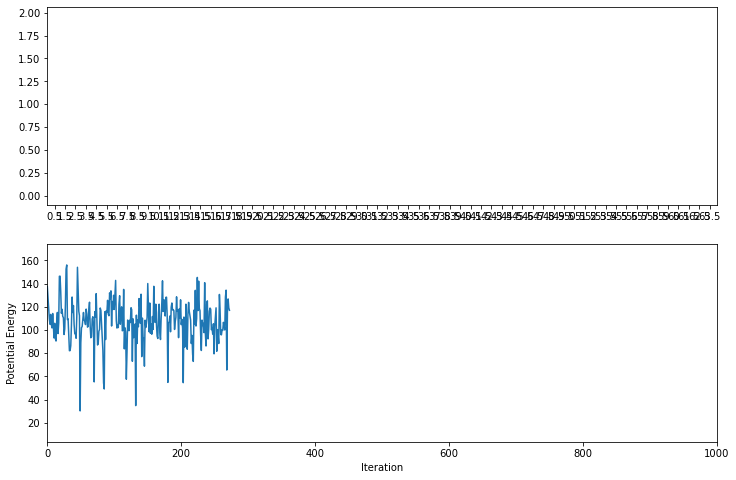

In [178]:
hold_d = dms_video(sampled_theta[:,0], sampled_energy[:,0])

In [81]:
check_me = run_filter(motif_filter)

In [84]:
check_me(sampled_theta[:,0])[10]

tensor([[676.8059,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000]])

In [181]:
hold_h = dmsheat_video(sampled_theta[:,0], sampled_energy[:,0], check_me, target='test_motif.mp4')

In [105]:
tensor_to_pandas(sampled_theta[0,0])

,site,letter,height,color
0,0,A,3.172076,green
1,1,A,4.757751,green
2,2,A,0.349964,green
3,3,A,3.829386,green
4,4,A,0.130407,green
...,...,...,...,...
67,13,T,2.188555,red
68,14,T,-2.300737,red
69,15,T,0.316460,red
70,16,T,2.774472,red


    site letter    height  color
0      0      A  1.598555  green
1      1      A  0.305983  green
2      2      A  0.001958  green
3      3      A  1.865755  green
4      4      A  0.054917  green
..   ...    ...       ...    ...
67    13      T  0.170156    red
68    14      T  0.014739    red
69    15      T  0.036716    red
70    16      T  1.148593    red
71    17      T  0.000892    red

[72 rows x 4 columns]
    site letter    height  color overlay_0
0      0      A  1.598555  green   #360e24
1      1      A  0.305983  green   #e6f1f1
2      2      A  0.001958  green   #e6f1f1
3      3      A  1.865755  green   #e6f1f1
4      4      A  0.054917  green   #e6f1f1
..   ...    ...       ...    ...       ...
67    13      T  0.170156    red   #e6f1f1
68    14      T  0.014739    red   #e6f1f1
69    15      T  0.036716    red   #e6f1f1
70    16      T  1.148593    red   #e6f1f1
71    17      T  0.000892    red   #e6f1f1

[72 rows x 5 columns]


(<Figure size 478.8x201.6 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:xlabel='site', ylabel='height'>],
       dtype=object))

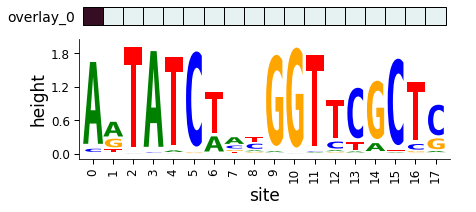

In [118]:
tensor_to_dmsheat(sampled_theta[0,0], check_me)

In [138]:
my_energy(sampled_theta[-20:,0])

tensor([ -773.4883,  -817.0892,  -737.0864,  -569.4933,  -572.2421,  -584.5511,
         -609.8351,  -757.9335,  -754.5117,  -882.7224,  -852.3984,  -805.4769,
         -866.3014,  -848.2695, -1006.5487, -1124.1703, -1241.8026, -1245.3708,
        -1261.7209, -1261.7209])

In [137]:
sampled_energy[-20:,0]

tensor([18.1644, 22.0910, 19.1911, 16.2472, 16.0655, 13.0726, 18.5254, 18.9793,
        15.7457, 15.8033, 15.3670,  8.0069,  9.1533, 13.7020, 12.5001, 13.8310,
        14.6548, 15.2760, 15.9075, 13.2945])

In [136]:
my_sampler.params.prior_nll()

tensor([28.6396], grad_fn=<MeanBackward1>)

In [148]:
my_sampler.params.theta.data = sampled_theta[-1,]

In [149]:
my_sampler.params.theta.shape

torch.Size([1, 4, 18])

In [151]:
my_energy( my_sampler.params.theta )

tensor([-1261.7211], grad_fn=<SumBackward1>)

In [150]:
my_sampler.params.rebatch( my_energy( my_sampler.params() ) )

tensor([-17.0434], grad_fn=<MeanBackward1>)